1. Gerekli kütüphaneler

In [11]:
# 🗃️ Veri okuma ve işleme
import pandas as pd  # Veri okuma, düzenleme ve DataFrame yapıları oluşturmak için

# 🌟 Makine öğrenmesi modelleri oluşturma
from sklearn.linear_model import LogisticRegression  # Lojistik Regresyon modelini oluşturmak ve sınıflandırma yapmak için
from sklearn.neighbors import KNeighborsClassifier  # K-En Yakın Komşu (KNN) algoritması ile sınıflandırma yapmak için
from sklearn.svm import SVC  # Destek Vektör Makineleri (SVM) ile sınıflandırma yapmak için
from sklearn.ensemble import VotingClassifier  # Birden fazla modelin oy birliğiyle sınıflandırma yapması için topluluk modeli oluşturma

# 📊 Model performans değerlendirmesi ve doğrulama metrikleri
from sklearn.metrics import classification_report  # Precision, Recall, F1-score gibi performans metriklerini elde etmek için
from sklearn.metrics import confusion_matrix  # Gerçek ve tahmin değerlerini karşılaştırmak için karmaşıklık matrisi oluşturma
from sklearn.metrics import roc_auc_score  # ROC eğrisi altında kalan alanı (AUC) hesaplamak için
from sklearn.metrics import roc_curve  # ROC eğrisi verilerini hesaplamak için (TPR ve FPR)

# 📈 Grafiksel görselleştirme ve analiz için
import seaborn as sns  # Grafiklerin estetiğini artırmak ve gelişmiş grafik türlerini kullanmak için
import matplotlib.pyplot as plt  # Grafik ve görselleştirme oluşturmak için (örneğin ROC eğrisi, karmaşıklık matrisi)

# ⚙️ Özellik ölçeklendirme işlemleri
from sklearn.preprocessing import StandardScaler  # Özelliklerin ölçeklendirilmesi (standartlaştırılması) için

# ⚖️ Sınıf dengesizlik sorununu çözmek için SMOTE yöntemi
from imblearn.over_sampling import SMOTE  # Azınlık sınıfını çoğaltarak sınıf dengesizliğini gidermek için

# 🧮 Sınıf dağılımını analiz etmek ve saymak için
from collections import Counter  # Verideki sınıfların dağılımını sayısal olarak göstermek için

2. Veriyi okuma

In [12]:
# Eğitim ve test verilerini oku
train_df = pd.read_csv("../datasets/normal/train_mental.csv")
test_df = pd.read_csv("../datasets/normal/test_mental.csv")

# Özellik ve hedef ayır (✅ doğru hedef sütunu kullanılıyor)
X_train = train_df.drop("support_needed", axis=1)
y_train = train_df["support_needed"]

X_test = test_df.drop("support_needed", axis=1)
y_test = test_df["support_needed"]

print("✅ Eğitim verisi:", X_train.shape)
print("✅ Test verisi:", X_test.shape)
print("🎯 Sınıf dağılımı (y_train):\n", y_train.value_counts())

✅ Eğitim verisi: (1007, 23)
✅ Test verisi: (252, 23)
🎯 Sınıf dağılımı (y_train):
 support_needed
0    528
1    479
Name: count, dtype: int64


3. SMOTE ile veri dengeleme

In [13]:
# 1. Özellikleri standartlaştır
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. SMOTE ile dengele
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print("📊 SMOTE sonrası sınıf dağılımı:", Counter(y_train_balanced))

📊 SMOTE sonrası sınıf dağılımı: Counter({0: 528, 1: 528})


4. Modellerin tanımı

In [14]:
svm_model = SVC(probability=True, kernel='linear', random_state=42)
lr_model = LogisticRegression(max_iter=1000, random_state=42)
knn_model = KNeighborsClassifier(n_neighbors=5)

5. Voting Classifier

In [15]:
# Voting Classifier (yalnızca sklearn modelleriyle)
voting_clf = VotingClassifier(
    estimators=[
        ('svm', svm_model),
        ('lr', lr_model),
        ('knn', knn_model),
    ],
    voting='soft'
)

# Eğit
voting_clf.fit(X_train_balanced, y_train_balanced)

VotingClassifier(estimators=[('svm',
                              SVC(kernel='linear', probability=True,
                                  random_state=42)),
                             ('lr',
                              LogisticRegression(max_iter=1000,
                                                 random_state=42)),
                             ('knn', KNeighborsClassifier())],
                 voting='soft')

6. Tahmin

In [16]:
# Tahmin
y_pred = voting_clf.predict(X_test_scaled)
y_proba = voting_clf.predict_proba(X_test_scaled)[:, 1]

7. Değerlendirme

📋 Topluluk Sınıflandırma Raporu (SVM - LogReg - KNN):

              precision    recall  f1-score   support

           0      0.835     0.803     0.819       132
           1      0.792     0.825     0.808       120

    accuracy                          0.813       252
   macro avg      0.813     0.814     0.813       252
weighted avg      0.814     0.813     0.814       252



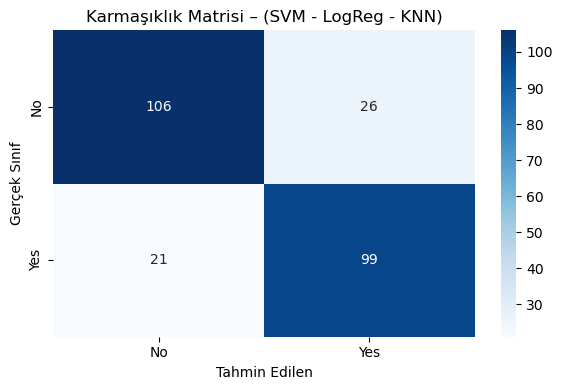

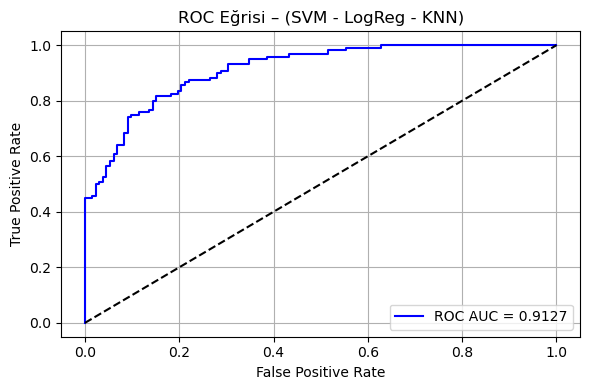

In [17]:
# 📋 Sınıflandırma raporu
print("📋 Topluluk Sınıflandırma Raporu (SVM - LogReg - KNN):\n")
report = classification_report(y_test, y_pred, digits=3)  # 3 basamak hassasiyeti
print(report)

# 🔍 Karmaşıklık Matrisi
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
plt.title("Karmaşıklık Matrisi – (SVM - LogReg - KNN)")
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek Sınıf")
plt.tight_layout()
plt.show()

# 🌈 ROC Eğrisi
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.4f}", color="blue")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Eğrisi – (SVM - LogReg - KNN)")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()

8. Model kaydı

In [19]:
import joblib

# model.save("../saved_model/normal/mental_vc_model.keras")
joblib.dump(voting_clf, "../saved_model/normal/mental_vc_model.pkl")

print("💾 Model başarıyla kaydedildi:")
print("- mental_vc_model.pkl")

💾 Model başarıyla kaydedildi:
- mental_vc_model.pkl
